### Loading data from Local drive filename: ai4i2020

In [1]:
# Step 1.
# Downloading csv from local drive
# imports

import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving ai4i2020_dropdcols.csv to ai4i2020_dropdcols.csv


### Read data into dataframe

In [2]:
df_cnc = pd.read_csv('ai4i2020_dropdcols.csv')
df_cnc.head(5)

Type  Air temperature [K]  ...  Tool wear [min]  Machine failure
0    M                298.1  ...                0                0
1    L                298.2  ...                3                0
2    L                298.1  ...                5                0
3    L                298.2  ...                7                0
4    L                298.2  ...                9                0

[5 rows x 7 columns]

In [3]:
df_cnc.shape

(10000, 7)

### Checking missing data

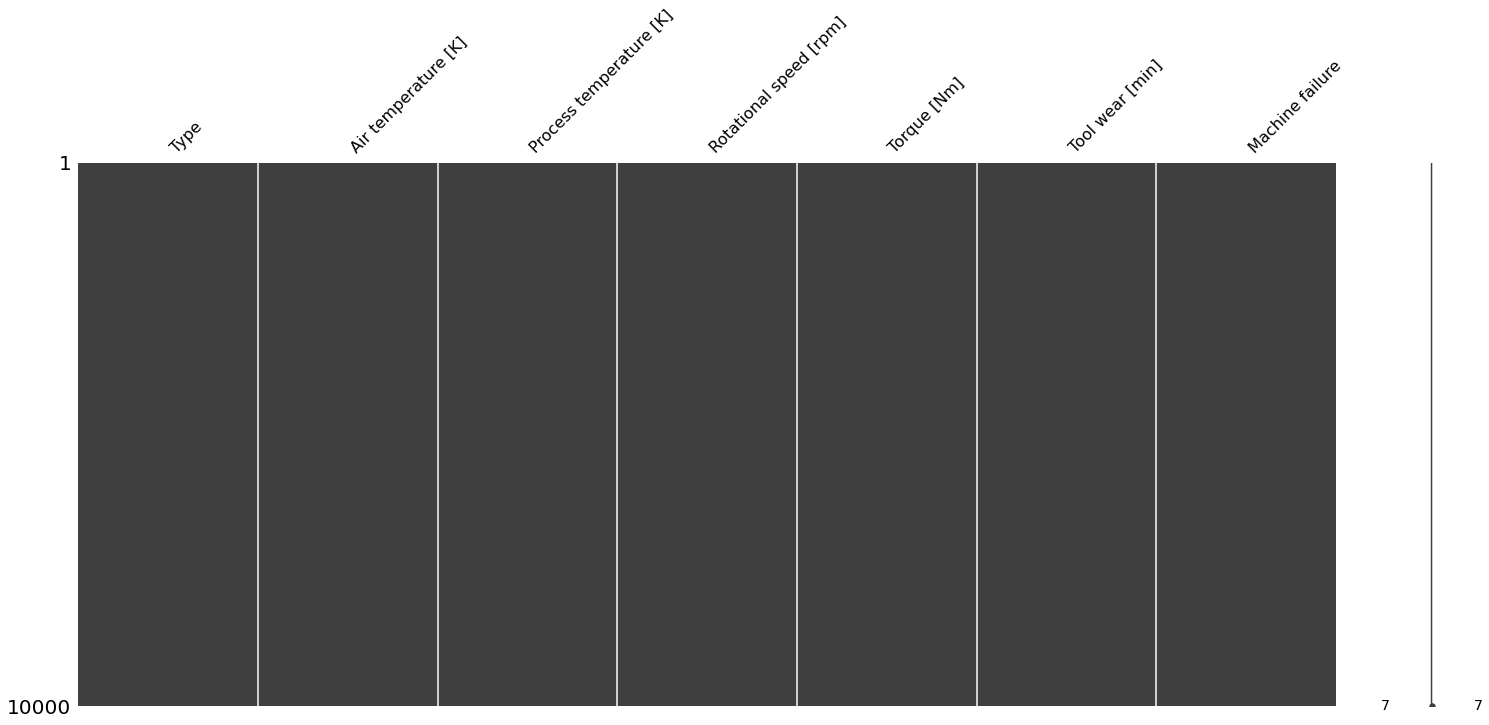

In [4]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

msno.matrix(df_cnc)
plt.show()


### Load Libraries

In [5]:
import numpy
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### Look at data types of each attribute

#### 6 numeric 1 object type found



In [6]:
set_option('display.max_rows',10)
print(df_cnc.dtypes)

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
dtype: object


#### Looking into dataset
#### They are of different scales

In [7]:
df_cnc.head(20)

Type  Air temperature [K]  ...  Tool wear [min]  Machine failure
0     M                298.1  ...                0                0
1     L                298.2  ...                3                0
2     L                298.1  ...                5                0
3     L                298.2  ...                7                0
4     L                298.2  ...                9                0
..  ...                  ...  ...              ...              ...
15    L                298.6  ...               42                0
16    M                298.6  ...               44                0
17    M                298.7  ...               47                0
18    H                298.8  ...               50                0
19    M                298.9  ...               55                0

[20 rows x 7 columns]

#### Data Summary

In [8]:
set_option('precision',3)
df_cnc.describe()

Air temperature [K]  ...  Machine failure
count            10000.000  ...        10000.000
mean               300.005  ...            0.034
std                  2.000  ...            0.181
min                295.300  ...            0.000
25%                298.300  ...            0.000
50%                300.100  ...            0.000
75%                301.500  ...            0.000
max                304.500  ...            1.000

[8 rows x 6 columns]

#### Looking at the break down of 'Type' distribution

In [9]:
print(df_cnc.groupby('Type').size())

Type
H    1003
L    6000
M    2997
dtype: int64


#### Looking at the break down of Machine failure
#### Observation: Imbalanced Classes zeros more compared to ones

In [10]:
print(df_cnc.groupby('Machine failure').size())

Machine failure
0    9661
1     339
dtype: int64


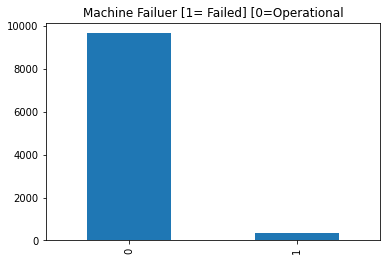

In [11]:
df_cnc['Machine failure'].value_counts().plot(kind='bar', title='Machine Failuer [1= Failed] [0=Operational');

#### Visual EDA to look at data distribution

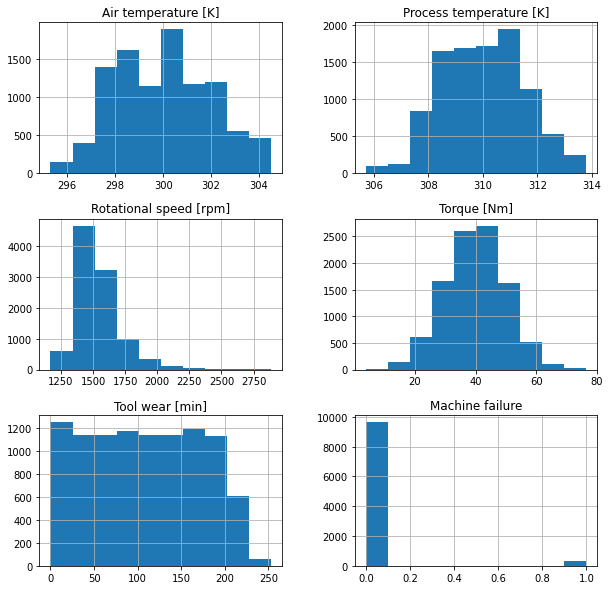

In [12]:
#histograms
df_cnc.hist(sharex=False,sharey=False, figsize=(10,10))
pyplot.show()

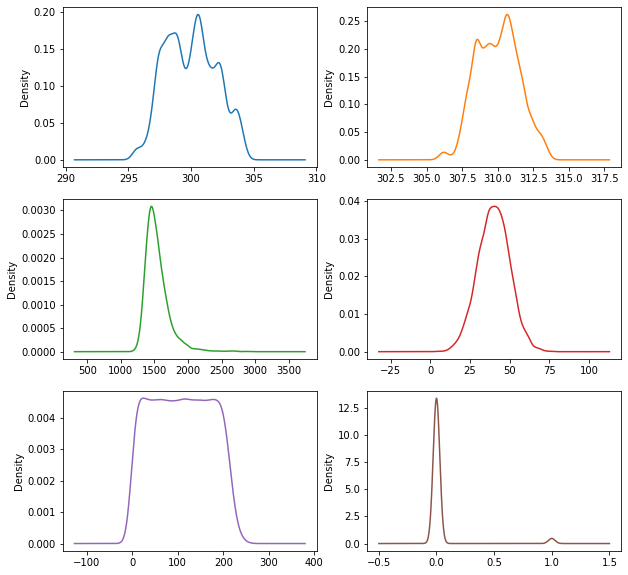

In [13]:
#Density plots
df_cnc.plot(kind='density',subplots=True, layout=(3,2),sharex=False,legend=False, figsize=(10,10))
pyplot.show()

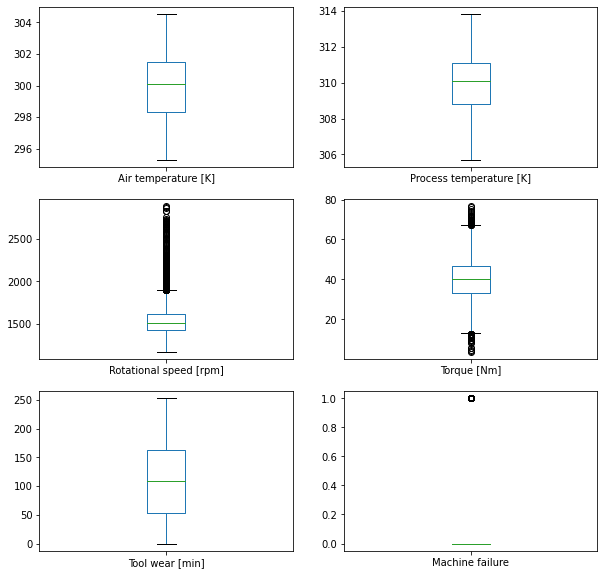

In [14]:
#box and whisker plots
df_cnc.plot(kind='box',subplots=True,layout=(3,2),sharex=False,sharey=False,figsize=(10,10))
pyplot.show()

#### Multimodal Data visualization

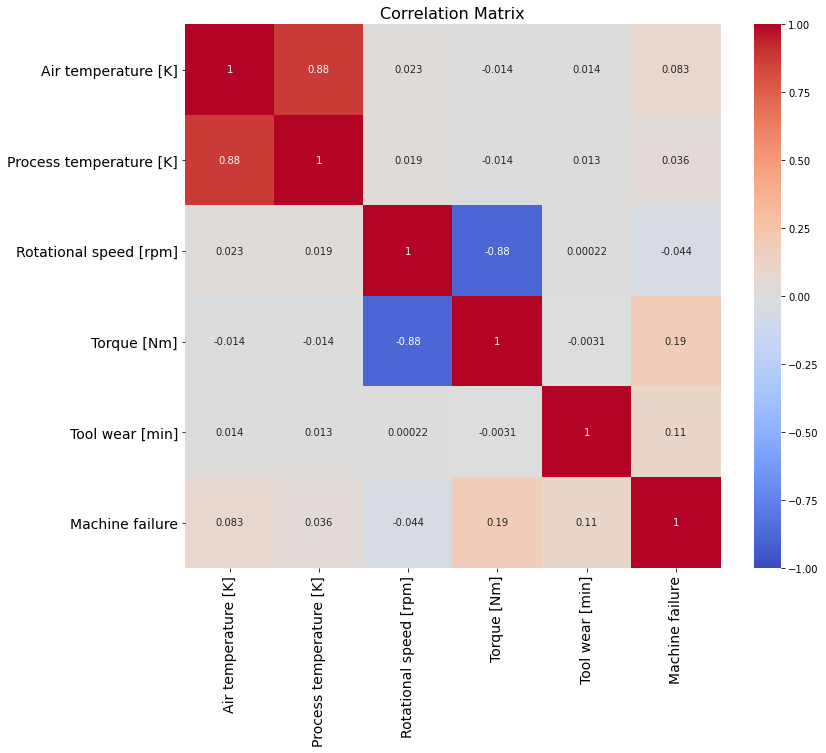

In [15]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(df_cnc[df_cnc.columns[df_cnc.columns != 'Type']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

#### Ordinal Encoding for 'Type' Column

In [16]:
#installing category_encoder
!pip install category_encoders

     |████████████████████████████████| 81kB 3.1MB/s 


In [17]:
#import for category_encoder
import category_encoders as ce
#create dictionary
dict_map = [{'col':'Type','mapping':{'L':0,'M':1,'H':2}}]
#instantiate the encoder
encoder = ce.OrdinalEncoder(cols='Type',mapping=dict_map)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
# encoding to new df
df_cnc_encoded = encoder.fit_transform(df_cnc)

In [19]:
df_cnc_encoded.head(10)

Type  Air temperature [K]  ...  Tool wear [min]  Machine failure
0     1                298.1  ...                0                0
1     0                298.2  ...                3                0
2     0                298.1  ...                5                0
3     0                298.2  ...                7                0
4     0                298.2  ...                9                0
5     1                298.1  ...               11                0
6     0                298.1  ...               14                0
7     0                298.1  ...               16                0
8     1                298.3  ...               18                0
9     1                298.5  ...               21                0

[10 rows x 7 columns]

### Validaiton Step

In [20]:
array = df_cnc_encoded.values
X = array[:,0:6]
Y = array[:,6]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y, test_size=validation_size,
                                                                random_state=seed)

### Oversampling on minority class [machine failures]

In [21]:
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Running baseline models with Accuracy as metric

In [22]:
# Setting test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy' #make_scorer(fbeta_score, beta=2)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: accuracy(%f) std(%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)


LR: accuracy(0.803722) std(0.008063)
LDA: accuracy(0.804303) std(0.008924)
KNN: accuracy(0.927128) std(0.045916)
CART: accuracy(0.967180) std(0.010232)
NB: accuracy(0.802818) std(0.018599)
SVM: accuracy(0.804438) std(0.036743)


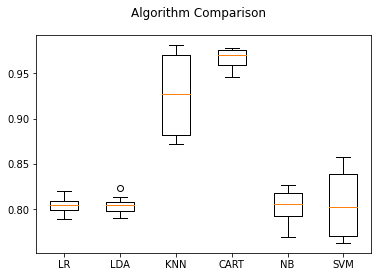

In [23]:
# Comparing Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Running same baseline with f-beta score as metric

In [24]:
# Doing the same as above now with f-beta score
# Setting test options and evaluation metric
num_folds = 10
seed = 7
scoring = make_scorer(fbeta_score, beta=2)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: f_beta(%f) std(%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)


LR: f_beta(0.611097) std(0.225875)
LDA: f_beta(0.613975) std(0.224882)
KNN: f_beta(0.778549) std(0.201536)
CART: f_beta(0.840164) std(0.145569)
NB: f_beta(0.607937) std(0.241877)
SVM: f_beta(0.620043) std(0.248431)


### Performing on a standardized data set

In [60]:
# Standardize the dataset
pipelines = []
scoring = 'accuracy'
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.805273 (0.009124)
ScaledLDA: 0.804303 (0.008924)
ScaledKNN: 0.959430 (0.028112)
ScaledCART: 0.967761 (0.009656)
ScaledNB: 0.802818 (0.018599)
ScaledSVM: 0.926737 (0.018776)


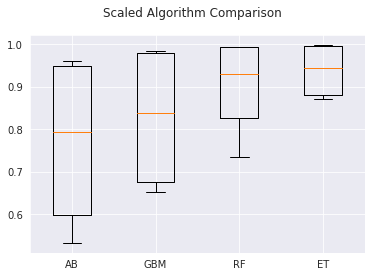

In [59]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
sns.set_style("darkgrid")
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [61]:
# Run this for Standardized setting using f-beta scoring
scoring = make_scorer(fbeta_score, beta=2)
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.612326 (0.228406)
ScaledLDA: 0.613975 (0.224882)
ScaledKNN: 0.845737 (0.144798)
ScaledCART: 0.840958 (0.145026)
ScaledNB: 0.607937 (0.241877)
ScaledSVM: 0.782547 (0.172768)


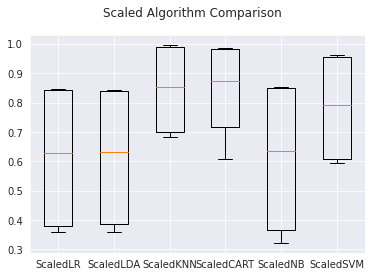

In [62]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
sns.set_style("darkgrid")
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Decision Tree Classifier and KNN seem to perform the best in terms of accuracy

#### We will therefore try to tune on 


*   KNN
*   CART



In [28]:
# Tune scaled KNN for accuracy metric
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
scoring = 'accuracy'
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975257 using {'n_neighbors': 1}
0.975257 (0.015341) with: {'n_neighbors': 1}
0.965631 (0.023065) with: {'n_neighbors': 3}
0.959171 (0.028011) with: {'n_neighbors': 5}
0.956717 (0.031246) with: {'n_neighbors': 7}
0.953358 (0.034174) with: {'n_neighbors': 9}
0.949158 (0.035917) with: {'n_neighbors': 11}
0.945347 (0.037464) with: {'n_neighbors': 13}
0.943409 (0.038080) with: {'n_neighbors': 15}
0.940695 (0.039864) with: {'n_neighbors': 17}
0.938757 (0.040800) with: {'n_neighbors': 19}
0.936366 (0.039528) with: {'n_neighbors': 21}


In [29]:
# Tune Decision Tree Classifier
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
tree_depth = [2,3,4,5,6,7,8,9,10]
param_grid = dict(max_depth=tree_depth)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX,Y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.958458 using {'max_depth': 10}
0.819161 (0.021191) with: {'max_depth': 2}
0.839967 (0.025676) with: {'max_depth': 3}
0.909164 (0.024645) with: {'max_depth': 4}
0.919565 (0.016374) with: {'max_depth': 5}
0.934294 (0.010233) with: {'max_depth': 6}
0.942693 (0.008703) with: {'max_depth': 7}
0.951609 (0.015784) with: {'max_depth': 8}
0.953548 (0.014596) with: {'max_depth': 9}
0.958458 (0.012418) with: {'max_depth': 10}


In [30]:
# For f-beta scoring
scoring = make_scorer(fbeta_score, beta=2)
# Tune Decision Tree Classifier
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
tree_depth = [2,3,4,5,6,7,8,9,10]
param_grid = dict(max_depth=tree_depth)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX,Y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.834233 using {'max_depth': 10}
0.626823 (0.221277) with: {'max_depth': 2}
0.656182 (0.195052) with: {'max_depth': 3}
0.742447 (0.203141) with: {'max_depth': 4}
0.764669 (0.182220) with: {'max_depth': 5}
0.797197 (0.155514) with: {'max_depth': 6}
0.798904 (0.162081) with: {'max_depth': 7}
0.811613 (0.162540) with: {'max_depth': 8}
0.821238 (0.154916) with: {'max_depth': 9}
0.834233 (0.144534) with: {'max_depth': 10}


### Ensemble methods

In [31]:
# ensembles
scoring = 'accuracy'
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: 0.931905 (0.008925)
GBM: 0.958653 (0.017069)
RF: 0.981071 (0.010164)
ET: 0.985981 (0.008422)


In [55]:
#ensemble for f-beta score
scoring = make_scorer(fbeta_score, beta=2)
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: 0.771686 (0.181383)
GBM: 0.827827 (0.153449)
RF: 0.903610 (0.093298)
ET: 0.937381 (0.058075)


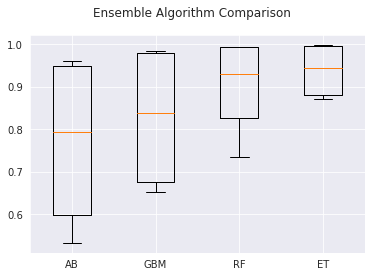

In [56]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
sns.set_style("darkgrid")
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Fine Tuning Extra Tree Regressor

In [67]:
#ensemble for f-beta score
scoring = make_scorer(fbeta_score, beta=2)
# Tune GBM to accuracy
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
estimator = [100]
minimum_sample_leaf = [1]
param_grid = dict(n_estimators=estimator, min_samples_leaf=minimum_sample_leaf)
model = ExtraTreesClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX,Y_train) #rescaledX
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.934006 using {'min_samples_leaf': 1, 'n_estimators': 100}
0.934006 (0.061338) with: {'min_samples_leaf': 1, 'n_estimators': 100}


### Confusion Matrix for ET

0.9675
[[1877   45]
 [  20   58]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1922
         1.0       0.56      0.74      0.64        78

    accuracy                           0.97      2000
   macro avg       0.78      0.86      0.81      2000
weighted avg       0.97      0.97      0.97      2000



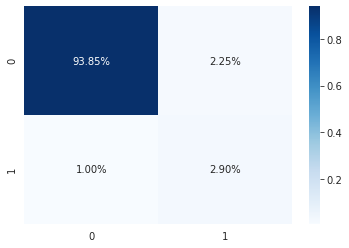

In [69]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=1)
model.fit(rescaledX, Y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
cf_matrix = confusion_matrix(Y_validation, predictions)
print(accuracy_score(Y_validation, predictions))
print(cf_matrix)
print(classification_report(Y_validation, predictions))
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot=True, fmt='.2%',cmap='Blues')

Text(0.5, 33.0, 'Predicted Label')

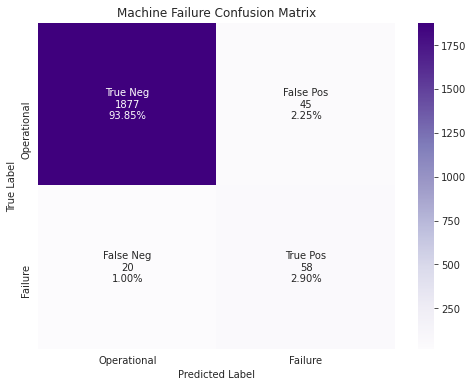

In [78]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

f,ax = plt.subplots(1,1,figsize=(8,6))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= 'Purples')
ax.xaxis.set_ticklabels(['Operational', 'Failure']); 
ax.yaxis.set_ticklabels(['Operational', 'Failure']);
plt.title('Machine Failure Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

### Fine Tuning GBM

In [34]:
# Tune GBM to accuracy
scoring = 'accuracy'
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
tree_depth = [2,3,4,5,6,7,8,9,10]
minimum_sample_leaf = [10,20,30,50]
param_grid = dict(max_depth=tree_depth, min_samples_leaf=minimum_sample_leaf)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX,Y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.984430 using {'max_depth': 9, 'min_samples_leaf': 30}
0.933263 (0.019679) with: {'max_depth': 2, 'min_samples_leaf': 10}
0.932682 (0.019487) with: {'max_depth': 2, 'min_samples_leaf': 20}
0.933328 (0.020362) with: {'max_depth': 2, 'min_samples_leaf': 30}
0.932488 (0.019343) with: {'max_depth': 2, 'min_samples_leaf': 50}
0.958266 (0.018152) with: {'max_depth': 3, 'min_samples_leaf': 10}
0.959687 (0.017020) with: {'max_depth': 3, 'min_samples_leaf': 20}
0.958589 (0.017119) with: {'max_depth': 3, 'min_samples_leaf': 30}
0.958395 (0.016543) with: {'max_depth': 3, 'min_samples_leaf': 50}
0.968021 (0.013127) with: {'max_depth': 4, 'min_samples_leaf': 10}
0.968021 (0.013222) with: {'max_depth': 4, 'min_samples_leaf': 20}
0.968086 (0.012869) with: {'max_depth': 4, 'min_samples_leaf': 30}
0.967698 (0.013205) with: {'max_depth': 4, 'min_samples_leaf': 50}
0.975321 (0.009824) with: {'max_depth': 5, 'min_samples_leaf': 10}
0.974610 (0.010423) with: {'max_depth': 5, 'min_samples_leaf': 20}


In [35]:
#ensemble for f-beta score
scoring = make_scorer(fbeta_score, beta=2)
# Tune GBM to accuracy
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
tree_depth = [2,3,4,5,6,7,8,9,10]
minimum_sample_leaf = [10,20,30,50]
param_grid = dict(max_depth=tree_depth, min_samples_leaf=minimum_sample_leaf)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX,Y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.910278 using {'max_depth': 10, 'min_samples_leaf': 20}
0.784583 (0.177651) with: {'max_depth': 2, 'min_samples_leaf': 10}
0.785011 (0.176837) with: {'max_depth': 2, 'min_samples_leaf': 20}
0.784344 (0.178743) with: {'max_depth': 2, 'min_samples_leaf': 30}
0.782728 (0.178905) with: {'max_depth': 2, 'min_samples_leaf': 50}
0.827899 (0.153776) with: {'max_depth': 3, 'min_samples_leaf': 10}
0.830718 (0.151455) with: {'max_depth': 3, 'min_samples_leaf': 20}
0.830786 (0.150313) with: {'max_depth': 3, 'min_samples_leaf': 30}
0.827664 (0.152989) with: {'max_depth': 3, 'min_samples_leaf': 50}
0.853544 (0.131786) with: {'max_depth': 4, 'min_samples_leaf': 10}
0.853435 (0.132427) with: {'max_depth': 4, 'min_samples_leaf': 20}
0.853127 (0.132987) with: {'max_depth': 4, 'min_samples_leaf': 30}
0.850622 (0.136531) with: {'max_depth': 4, 'min_samples_leaf': 50}
0.874998 (0.117714) with: {'max_depth': 5, 'min_samples_leaf': 10}
0.868788 (0.122097) with: {'max_depth': 5, 'min_samples_leaf': 20}

### Final Model Performance
#### Gradient Boosting

0.9645
[[1872   50]
 [  21   57]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1922
         1.0       0.53      0.73      0.62        78

    accuracy                           0.96      2000
   macro avg       0.76      0.85      0.80      2000
weighted avg       0.97      0.96      0.97      2000



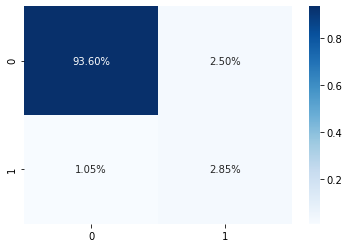

In [36]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingClassifier(max_depth=10,min_samples_leaf=10)
model.fit(rescaledX, Y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
cf_matrix = confusion_matrix(Y_validation, predictions)
print(accuracy_score(Y_validation, predictions))
print(cf_matrix)
print(classification_report(Y_validation, predictions))
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot=True, fmt='.2%',cmap='Blues')

Text(0.5, 33.0, 'Predicted Label')

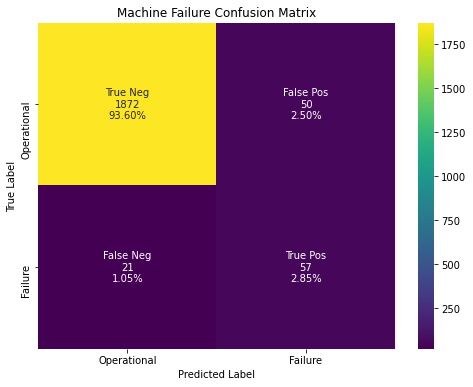

In [49]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

f,ax = plt.subplots(1,1,figsize=(8,6))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= 'Blues')
ax.xaxis.set_ticklabels(['Operational', 'Failure']); 
ax.yaxis.set_ticklabels(['Operational', 'Failure']);
plt.title('Machine Failure Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
